WE should use percision score since we care about mostly identifying who has pneumonia

# Preparation

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras import Input, Model
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [2]:
pneumonia_images = []
healthy_images = []
import os
import struct
import numpy as np
import glob
import cv2
images = glob.glob("chest_xray/test/NORMAL/*")
for image in images:
    im = cv2.imread(image,0)
    im = cv2.resize(im,(200,200))
    im = im.flatten()/255 -.5
    healthy_images.append(im)
images = glob.glob("chest_xray/test/PNEUMONIA/*")
for image in images:
    im = cv2.imread(image,0)
    im = cv2.resize(im,(200,200))
    im = im.flatten()/255 -.5
    pneumonia_images.append(im)


In [3]:
#Now lets put them together with y values
healthy_images
b = np.zeros((len(healthy_images),1))
a = np.ones((len(pneumonia_images),1))
healthy_images = np.hstack((healthy_images, b))
pneumonia_images = np.hstack((pneumonia_images, a))
images = np.vstack([healthy_images, pneumonia_images])

In [4]:
y = images[:,-1]
X = images[:,:-1]

# folding below
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
img_wh = 200
y_test_ohe = keras.utils.to_categorical(y_test, 2)
y_train_ohe = keras.utils.to_categorical(y_train, 2)
X_train_img = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
X_test_img = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)
folds = StratifiedKFold(n_splits=5,random_state=1).split(X_train, y_train)


In [5]:
y_train_ohe

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.

# Modeling

In [6]:
y_test

array([1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0.,
       0., 0., 1., 1., 1., 1.])

In [7]:

#this is expansion on the dataset. This is a slower way to do it. When we use a keras generator we call .fit on a python generator
#this will yield batches

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False, #do we want to make it 0 mean
    featurewise_std_normalization=False, #do we take the whole batch and make it 0 mean, no
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations. Randomly rotate images 5 degrees 
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts. 
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False, 
    rescale=None) #this generator will esentially run forever. This will manipulate our data, will give us different datasets every time


In [8]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import numpy as np
np.random.seed(1000)
#Instantiate an empty model
#get a bigger dataset
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=32, input_shape=(200,200,1), kernel_size=(14,14),  padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(7,7), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid', data_format="channels_last"))

# 3rd Convolutional Layer
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid', data_format="channels_last"))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', data_format="channels_last"))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid', data_format="channels_last"))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 187, 187, 32)      6304      
_________________________________________________________________
activation (Activation)      (None, 187, 187, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 93, 93, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        100416    
_________________________________________________________________
activation_1 (Activation)    (None, 87, 87, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       7

In [ ]:
scores = []
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('alexNet_log.csv', append=True, separator=';')
histories= []
#datagen.fit(X_train)
print(folds)
for k, (train, test) in enumerate(folds):
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=[keras.metrics.Recall()])
    print("new fold")
    datagen.fit(X_train_img)
    histories.append(model.fit_generator(datagen.flow(X_train_img[train], y_train_ohe[train], batch_size=32),
             steps_per_epoch=int(len(X_train)/2),
             epochs=10, verbose=1,
             validation_data=(X_test_img,y_test_ohe),
             callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
             ))


In [9]:
old_histories = histories

NameError: name 'histories' is not defined

In [ ]:
histories

In [ ]:
old_histories["loss"]

In [ ]:
old_histories[0].history

In [ ]:
test = old_histories

In [ ]:
test

In [ ]:
with open("alexnet.txt", "w") as f:
    for history in test:
        print(history.history, file=f)

<h4>Convolution Neural Network</h4>

In [9]:
# ResNet style architecture
# We will also use ReLU where approriate and drop out 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import average, concatenate
from tensorflow.keras import Input, Model

l2_lambda = 0.000001
input_holder = Input(shape=(img_wh, img_wh, 1))
NUM_CLASSES = 2

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

resnet = Model(inputs=input_holder,outputs=x)

resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 1) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 200, 200, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 100, 100, 32) 0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 100, 100, 32) 9248        max_pooling2d_3[0][0]            
______________________________________________________________________________________________

In [10]:
%%time

from tensorflow.keras.callbacks import CSVLogger
from sklearn.metrics import roc_curve, auc

csv_logger_resnet = CSVLogger('resnet_log.csv', append=True, separator=';')
histories_resnet = []
y_preds_resnet = []
fpr_resnet = []
tpr_resnet = []
auc_resnet = []
thresholds_resnet = []

# the flow method yields batches of images indefinitely, with the given transformations
for k, (train, test) in enumerate(folds):
    resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                    optimizer='adam', # 'adadelta' 'rmsprop'
                    metrics=[tensorflow.keras.metrics.Recall()])
    print("New fold")
    datagen.fit(X_train_img)
    
    # the flow method yields batches of images indefinitely, with the given transofmrations
    # size of X_train_img[train] is only 400, so def need more training data
    histories_resnet.append(resnet.fit_generator(datagen.flow(X_train_img[train], y_train_ohe[train], batch_size=32), 
                              steps_per_epoch=30, # how many generators to go through per epoch
                              epochs=10, verbose=1,
                              validation_data=(X_test_img,y_test_ohe),
                              callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                             ))
    ypred_keras = model.predict(X_test_img).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_ohe.ravel(), ypred_keras)
    auc_keras = auc(fpr_keras, tpr_keras)
    fpr_resnet.append(fpr_keras)
    tpr_resnet.append(tpr_keras)
    auc_resnet.append(auc_keras)
    y_preds_resnet.append(ypred_keras)
    thresholds_resnet.append(thresholds_keras)

New fold
Epoch 1/10
30/30 [==============================] - 29s 965ms/step - loss: 1.2026 - recall: 0.6537 - val_loss: 0.4304 - val_recall: 0.7840
Epoch 2/10
30/30 [==============================] - 29s 958ms/step - loss: 0.4132 - recall: 0.8095 - val_loss: 0.2777 - val_recall: 0.8720
Epoch 3/10
30/30 [==============================] - 28s 942ms/step - loss: 0.3633 - recall: 0.8245 - val_loss: 0.3009 - val_recall: 0.8560
Epoch 4/10
30/30 [==============================] - 29s 952ms/step - loss: 0.3803 - recall: 0.8245 - val_loss: 0.2606 - val_recall: 0.8960
Epoch 5/10
30/30 [==============================] - 29s 970ms/step - loss: 0.3518 - recall: 0.8408 - val_loss: 0.2103 - val_recall: 0.9040
Epoch 6/10
30/30 [==============================] - 28s 940ms/step - loss: 0.3020 - recall: 0.8742 - val_loss: 0.1819 - val_recall: 0.9200
Epoch 7/10
30/30 [==============================] - 29s 959ms/step - loss: 0.2692 - recall: 0.8820 - val_loss: 0.2394 - val_recall: 0.8720
Epoch 8/10
30/30 [

In [11]:
y_pred_resnet = resnet.predict(X_test_img)
y_pred_resnet

array([[3.4318137e-04, 9.9965680e-01],
       [9.9641740e-01, 3.5825758e-03],
       [9.9997294e-01, 2.7022694e-05],
       [9.9956614e-01, 4.3383447e-04],
       [1.0651717e-02, 9.8934829e-01],
       [9.8200238e-01, 1.7997643e-02],
       [9.0927624e-06, 9.9999094e-01],
       [2.8139141e-01, 7.1860856e-01],
       [9.8807240e-01, 1.1927672e-02],
       [4.3601808e-01, 5.6398195e-01],
       [9.9997354e-01, 2.6513188e-05],
       [6.9778271e-02, 9.3022168e-01],
       [3.5092947e-03, 9.9649066e-01],
       [1.4078094e-03, 9.9859220e-01],
       [9.9984193e-01, 1.5803924e-04],
       [9.9961108e-01, 3.8896652e-04],
       [9.5448732e-01, 4.5512684e-02],
       [2.3957431e-02, 9.7604263e-01],
       [3.2674730e-01, 6.7325276e-01],
       [1.9632049e-02, 9.8036802e-01],
       [7.9198956e-04, 9.9920803e-01],
       [3.0417860e-04, 9.9969590e-01],
       [3.6284140e-01, 6.3715863e-01],
       [3.7662882e-02, 9.6233714e-01],
       [2.2633778e-01, 7.7366221e-01],
       [9.3651796e-03, 9.

In [12]:
print((fpr_resnet[0],tpr_resnet[0]))

(array([0.   , 0.008, 0.008, 0.016, 0.016, 0.024, 0.024, 0.04 , 0.04 ,
       0.048, 0.048, 0.072, 0.072, 0.12 , 0.12 , 0.2  , 0.2  , 0.216,
       0.216, 0.232, 0.232, 0.28 , 0.28 , 0.304, 0.304, 0.344, 0.344,
       0.384, 0.384, 0.416, 0.416, 0.424, 0.424, 0.44 , 0.44 , 0.48 ,
       0.48 , 0.488, 0.488, 0.496, 0.496, 0.504, 0.504, 0.56 , 0.56 ,
       0.584, 0.584, 0.592, 0.592, 0.6  , 0.6  , 0.608, 0.608, 0.624,
       0.624, 0.648, 0.648, 0.656, 0.656, 0.688, 0.688, 0.696, 0.696,
       0.704, 0.704, 0.712, 0.712, 0.72 , 0.72 , 0.736, 0.736, 0.752,
       0.752, 0.776, 0.776, 0.784, 0.784, 0.8  , 0.8  , 0.808, 0.808,
       0.816, 0.816, 0.832, 0.832, 0.84 , 0.84 , 0.856, 0.856, 0.872,
       0.872, 0.88 , 0.88 , 0.888, 0.888, 0.904, 0.904, 0.912, 0.912,
       0.928, 0.928, 0.936, 0.936, 0.944, 0.944, 1.   , 1.   ]), array([0.   , 0.   , 0.056, 0.056, 0.064, 0.064, 0.072, 0.072, 0.088,
       0.088, 0.096, 0.096, 0.112, 0.112, 0.12 , 0.12 , 0.128, 0.128,
       0.144, 0.144, 0.1

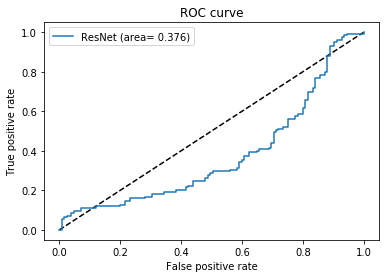

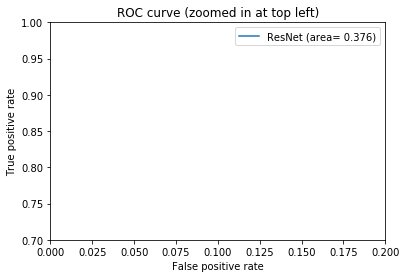

In [13]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fprs[0], tprs[0], label='AlexNet (area = {:.3f})'.format(aucs[0]))
# plt.plot(mlp_fprs[0], mlp_tprs[0], label='MLP (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_resnet[0], tpr_resnet[0], label='ResNet (area= {:.3f})'.format(auc_resnet[0]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fprs[0], tprs[0], label='AlexNet (area = {:.3f})'.format(aucs[0]))
# plt.plot(mlp_fprs[0], mlp_tprs[0], label='MLP (area = {:.3f})'.format(aucs[0]))
plt.plot(fpr_resnet[0], tpr_resnet[0], label='ResNet (area= {:.3f})'.format(auc_resnet[0])) # Resnet doesn't show up in this area
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [15]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_ohe[:,0], y_pred_resnet[:,0])
tpr_keras

array([0.        , 0.02325581, 0.76744186, 0.76744186, 0.81395349,
       0.81395349, 0.8372093 , 0.8372093 , 0.88372093, 0.88372093,
       0.90697674, 0.90697674, 0.97674419, 0.97674419, 1.        ,
       1.        ])

In [17]:
print(len(fpr_resnet[3]))

107


In [19]:
histories_resnet[0].history

{'loss': [1.1890580232267256,
  0.4130018817268925,
  0.36155534984654936,
  0.38294911746420873,
  0.3513498618850789,
  0.30026626635433296,
  0.26613065613296644,
  0.25800814178018344],
 'recall': [0.65367967,
  0.8095238,
  0.8245033,
  0.8245033,
  0.84076434,
  0.8741722,
  0.88203466,
  0.9025974],
 'val_loss': [0.43037228286266327,
  0.27765749394893646,
  0.30092963203787804,
  0.260570652782917,
  0.21031591668725014,
  0.18193893879652023,
  0.23943797498941422,
  0.28378458321094513],
 'val_recall': [0.784, 0.872, 0.856, 0.896, 0.904, 0.92, 0.872, 0.856]}

In [20]:
with open("resnet.txt",'w') as f:
    for history in histories_resnet:
        print(history.history, file=f)

In [21]:
import ast
histories = []
max_length = 0
with open("resnet.txt", "r") as f:
    line = f.readline()
    while line:
        histories.append(ast.literal_eval(line))
        line = f.readline()

In [22]:
histories[0]

{'loss': [1.1890580232267256,
  0.4130018817268925,
  0.36155534984654936,
  0.38294911746420873,
  0.3513498618850789,
  0.30026626635433296,
  0.26613065613296644,
  0.25800814178018344],
 'recall': [0.65367967,
  0.8095238,
  0.8245033,
  0.8245033,
  0.84076434,
  0.8741722,
  0.88203466,
  0.9025974],
 'val_loss': [0.43037228286266327,
  0.27765749394893646,
  0.30092963203787804,
  0.260570652782917,
  0.21031591668725014,
  0.18193893879652023,
  0.23943797498941422,
  0.28378458321094513],
 'val_recall': [0.784, 0.872, 0.856, 0.896, 0.904, 0.92, 0.872, 0.856]}

In [23]:
import numpy as np
recalls = np.array([list(v for k,v in history.items() if k.startswith('recall')) for history in histories])

In [24]:
tmp = []
for recall in recalls:
    tmp.append(recall[0])


In [25]:
x=[[1,2],[1,2,3],[1]]
length = max(map(len, tmp))
recalls=np.array([xi+[None]*(length-len(xi)) for xi in tmp])
recalls = np.array(recalls)

In [26]:
means = []
for row in range(len(recalls[0])):
    sum = 0
    count = 0
    for item in recalls[:,row]:
        if item != None:
            count += 1
            sum += item
    means.append(sum/count)

In [27]:
means

[0.846049968,
 0.8855276440000001,
 0.890885168,
 0.893910762,
 0.8862489299999999,
 0.90152575,
 0.9027630099999999,
 0.9025974]